**Context**
Important note about the dataset:

- `baseline value`- FHR baseline (beats per minute)
- `accelerations` - Number of accelerations per second
- `fetal_movement` - Number of fetal movements per second
- `uterine_contractions` - Number of uterine contractions per second
- `light_decelerations` - Number of light decelerations per second
- `severe_decelerations `- Number of severe decelerations per second
- `prolongued_decelerations` - Number of prolonged decelerations per second
- `abnormal_short_term_variability` - Percentage of time with abnormal short term variability
- `mean_value_of_short_term_variability` - Mean value of short term variability
- `percentage_of_time_with_abnormal_long_term_variability` - Percentage of time with abnormal long term variability
- `mean_value_of_long_term_variability` - Mean value of long term variability
- `histogram_width` - Width of FHR histogram
- `histogram_min` - Minimum (low frequency) of FHR histogram
- `histogram_max` - Maximum (high frequency) of FHR histogram
- `histogram_number_of_peaks` - Number of histogram peaks
- `histogram_number_of_zeroes` - Number of histogram zeros
- `histogram_mode` - Histogram mode
- `histogram_mean` - Histogram mean
- `histogram_median` - Histogram median
- `histogram_variance` - Histogram variance
- `histogram_tendency` - Histogram tendency

Note: `fetal_health` is the target variable given, but we will remove it since it is not relevant to our context.


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

**Data Preprocessing**
1. Load Data (data is cleaned so there is no need to check for missing/errornous data)
2. Handle outliers

In [38]:
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
data = pd.read_csv("./input/fetal_health.csv")

# Remove fetal_health column
data = data.drop("fetal_health", axis=1)

# Z-score method to remove outliers (values that are 3 standard deviations away from the mean)
limit = 3
z_scores = stats.zscore(data.select_dtypes(include=[float, int]))
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < limit).all(axis=1)
data = data[filtered_entries]


      baseline value  accelerations  fetal_movement  uterine_contractions  \
0              120.0          0.000           0.000                 0.000   
1              132.0          0.006           0.000                 0.006   
2              133.0          0.003           0.000                 0.008   
3              134.0          0.003           0.000                 0.008   
4              132.0          0.007           0.000                 0.008   
...              ...            ...             ...                   ...   
2121           140.0          0.000           0.000                 0.007   
2122           140.0          0.001           0.000                 0.007   
2123           140.0          0.001           0.000                 0.007   
2124           140.0          0.001           0.000                 0.006   
2125           142.0          0.002           0.002                 0.008   

      light_decelerations  severe_decelerations  prolongued_decelerations  

**Feature Selection and Extraction**

This following steps aim to identify the important features that will be used to predict labour progression and reduce dimensionality

We will first perform Correlation Analysis to identify and remove highly correlated variables. Based on the heatmap, we can decide on which variables to drop (we can remove redundant features which are highly correlated to each other)

Findings:
We can observe that there is a high correlation between `baseline_value`, `histogram_mode`, `histogram_mean` and `histogram_median`. Therefore we will only choose to keep `baseline_value` since it provides the raw accurate data.


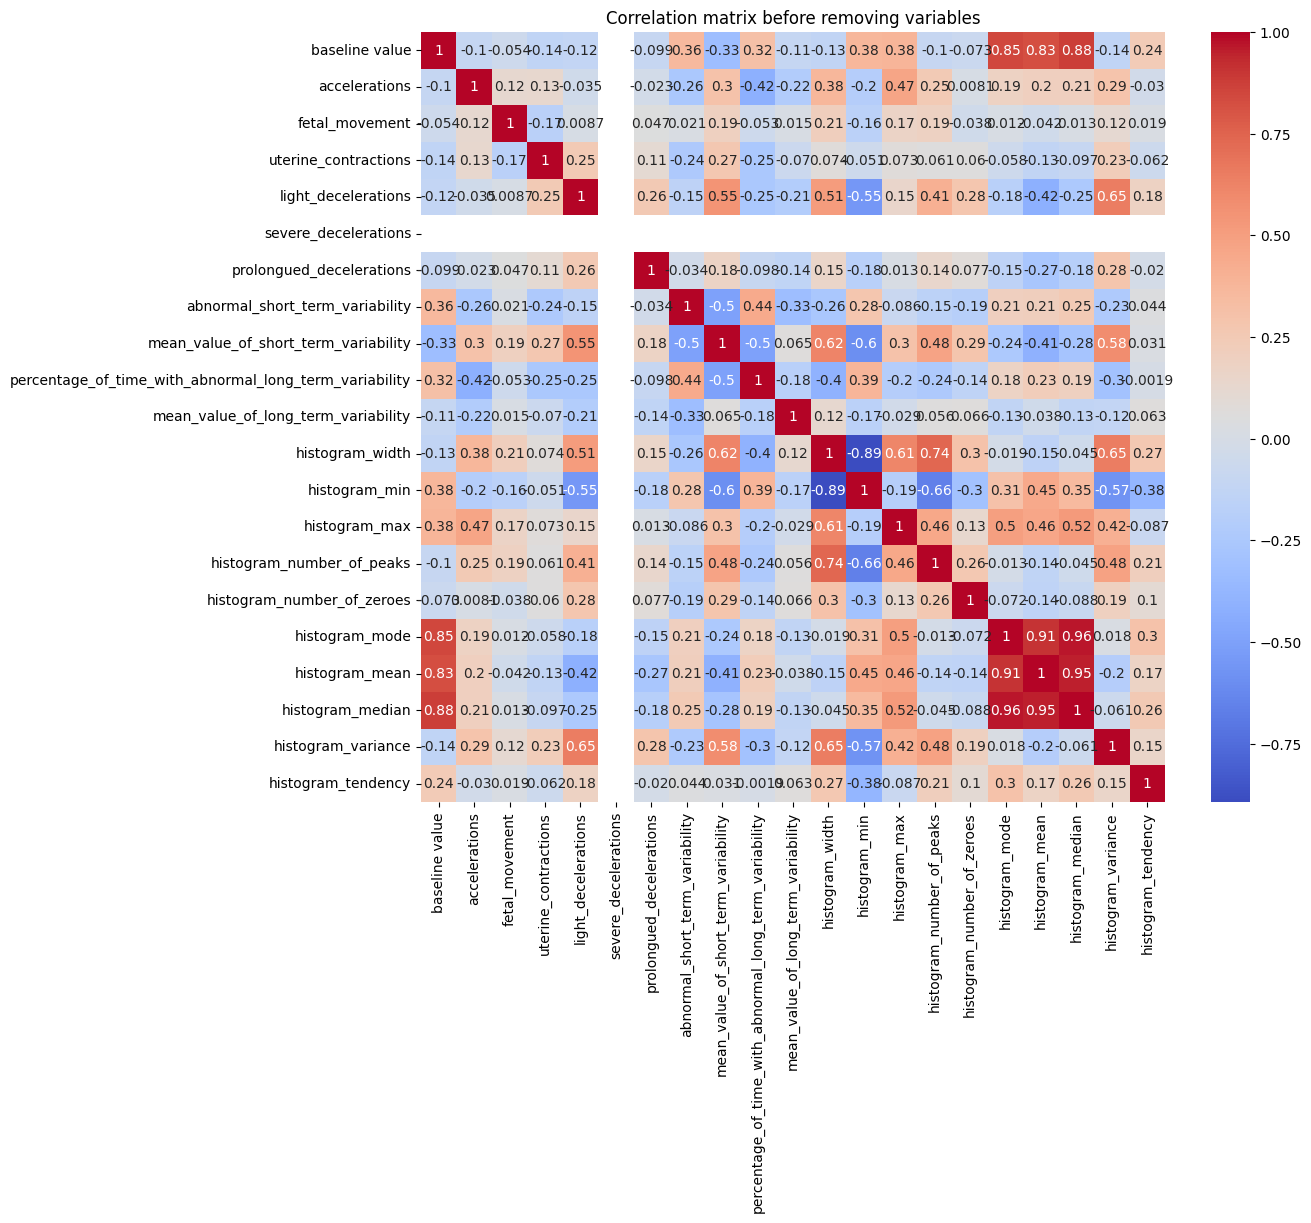

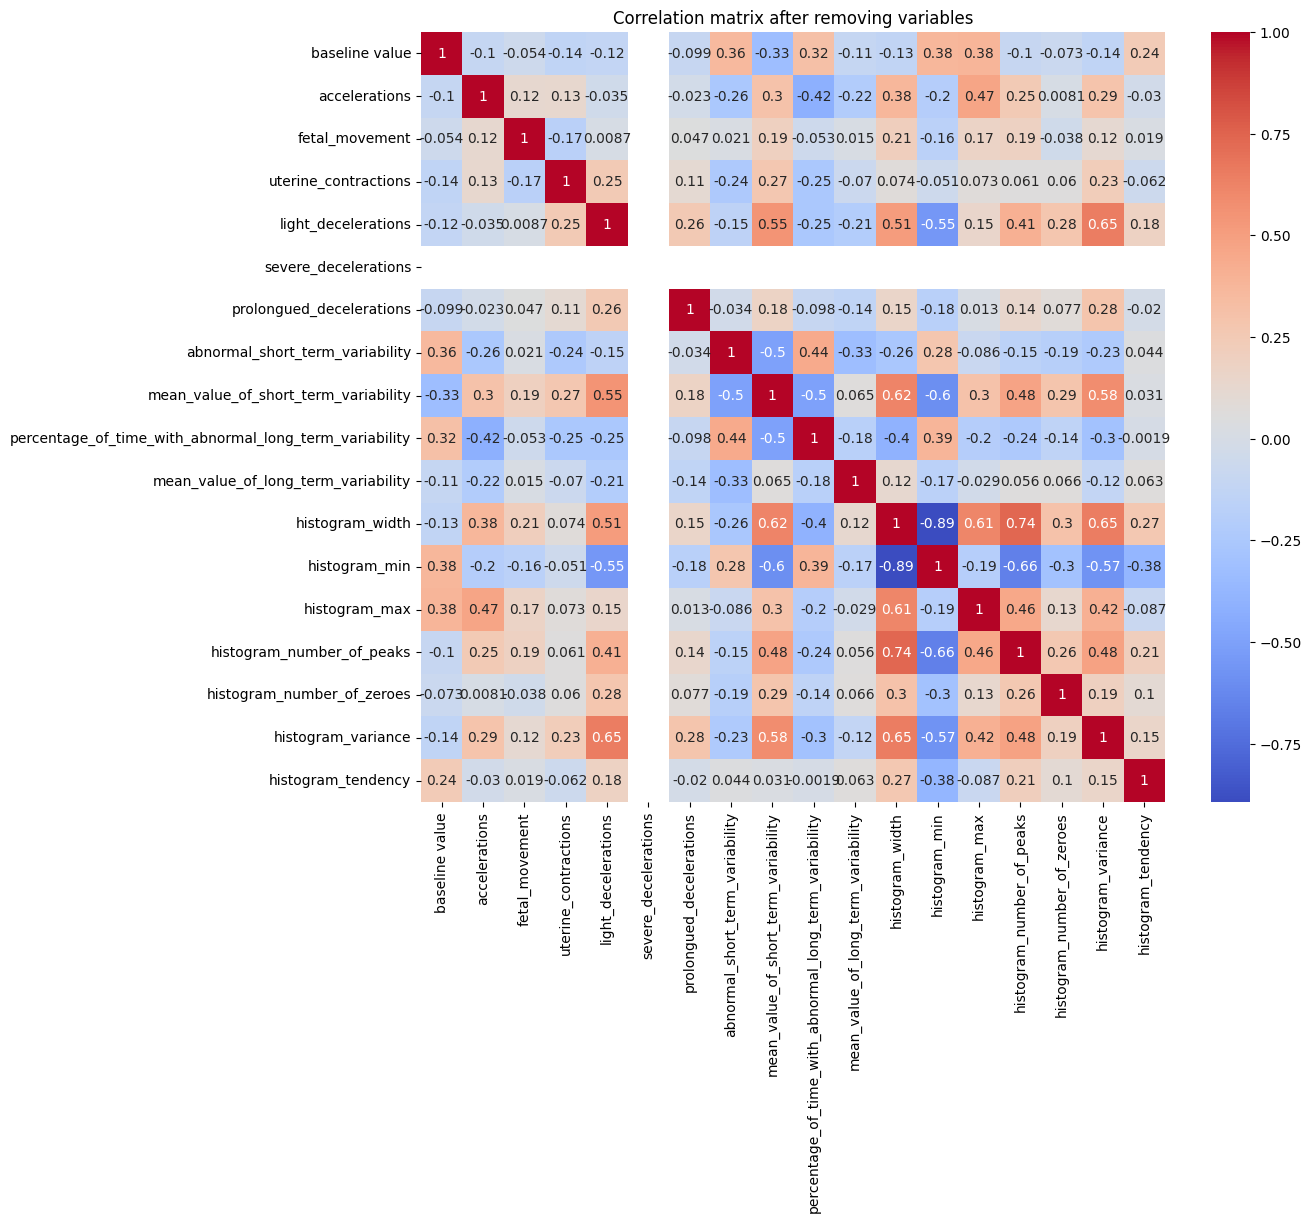

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix before removing variables')
plt.show()

# Drop the variables with high correlation
variables_to_drop = ['histogram_mean', 'histogram_mode', 'histogram_median']
data_reduced = data.drop(columns=variables_to_drop)


# Replot the correlation matrix after removing the variables
corr_matrix = data_reduced.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix after removing variables')
plt.show()


**Principal Component Analysis (PCA)**
PCA helps reduce the dimensionality of your dataset while retaining as much variance as possible. It transforms the original variables into a new set of uncorrelated variables (principal components).

We need to determine the number of components that are enough to explain the variance. This can be done by plotting the cumulative explained variance chart. This chart shows how many components are required to explain a given percentage of the variance, such as 80%, 90%, or 95%. By examining this chart, you can identify the point where adding more components yields diminishing returns, and thus select the optimal number of components to retain that will capture the desired amount of variance while reducing the dimensionality of your dataset.

Findings: We found out that 12 principal components are required to capture a sufficient amount of the variance (in this case, the threshold is set at 95%)

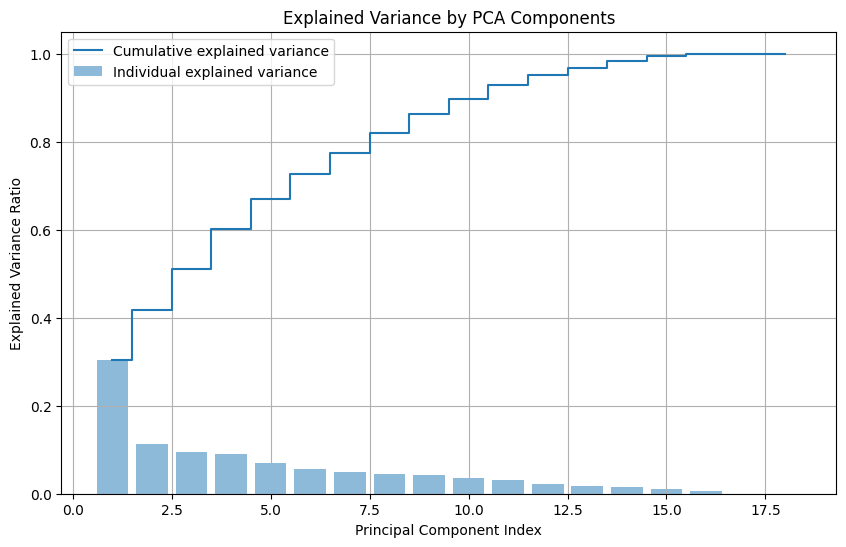

Number of components to retain: 12
Transformed DataFrame (first 5 rows):
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.724381  1.138214 -2.940061  0.797199  1.918906 -1.674663 -1.148924   
1  3.370636 -0.344025  1.248462 -0.632908 -1.276355  1.330149 -0.501847   
2  3.216001 -0.741564  0.837634 -0.697937 -1.757010  1.666446  0.173191   
3  3.655445 -1.060949 -0.625927 -2.426164 -1.576353 -0.104385  1.948071   
4  3.233024 -1.218157  0.425824 -2.327853 -1.291237 -0.718622  1.443911   

        PC8       PC9      PC10      PC11      PC12  
0 -0.165136 -1.352173  0.761661  1.353812  2.902020  
1  0.008230 -0.223641 -0.006111  0.454686 -0.438565  
2 -0.503294 -0.068865 -0.255651  0.293181 -0.105737  
3 -0.852173 -0.810474 -0.960210  0.734783 -1.275722  
4 -0.057530 -0.556248 -1.136304  1.128300 -0.756914  


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_reduced)

# Fit PCA with the maximum number of components (for visualization purposes)
pca = PCA(n_components=min(len(data_reduced.columns), len(data_reduced)))
pca.fit(scaled_data)

# Explained variance by each component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

# Determine the number of components to retain
threshold = 0.95
n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f'Number of components to retain: {n_components}')

# Fit PCA with the chosen number of components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(scaled_data)

# Convert to DataFrame for easier handling
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(n_components)])





**Clustering**

Note: We can plot an elbow plot to determine the appropriate number of clusters. In this case, it is 2.


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

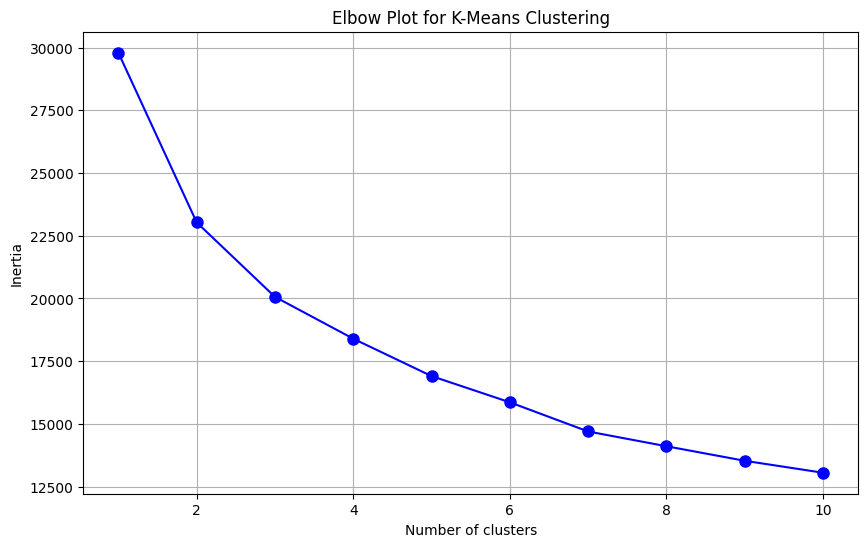

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PCA DataFrame with Cluster Labels:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.724381  1.138214 -2.940061  0.797199  1.918906 -1.674663 -1.148924   
1  3.370636 -0.344025  1.248462 -0.632908 -1.276355  1.330149 -0.501847   
2  3.216001 -0.741564  0.837634 -0.697937 -1.757010  1.666446  0.173191   
3  3.655445 -1.060949 -0.625927 -2.426164 -1.576353 -0.104385  1.948071   
4  3.233024 -1.218157  0.425824 -2.327853 -1.291237 -0.718622  1.443911   

        PC8       PC9      PC10      PC11      PC12  Cluster  
0 -0.165136 -1.352173  0.761661  1.353812  2.902020        1  
1  0.008230 -0.223641 -0.006111  0.454686 -0.438565        0  
2 -0.503294 -0.068865 -0.255651  0.293181 -0.105737        0  
3 -0.852173 -0.810474 -0.960210  0.734783 -1.275722        0  
4 -0.057530 -0.556248 -1.136304  1.128300 -0.756914        0  


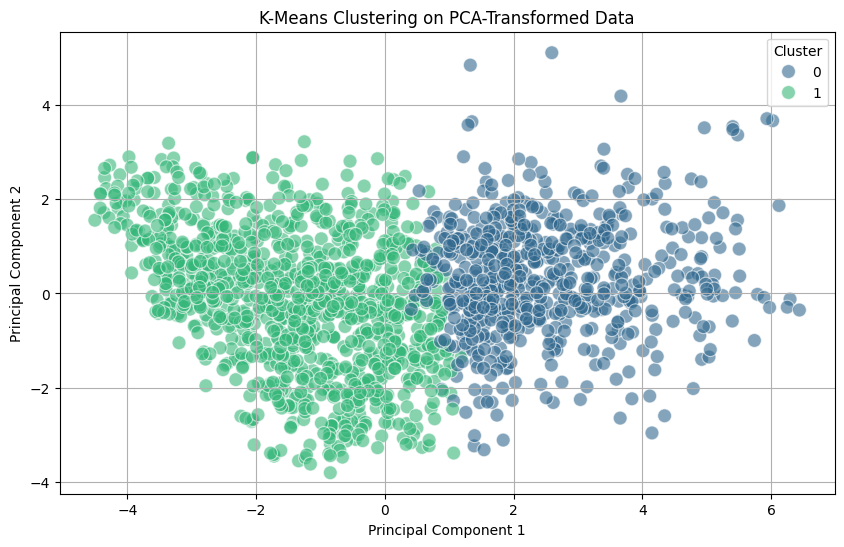

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Compute inertia for different number of clusters
inertia = []
K = range(1, 11)  # Trying from 1 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.grid(True)
plt.show()

# Fit K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Example with 3 clusters
kmeans.fit(pca_df)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = cluster_labels

print("PCA DataFrame with Cluster Labels:")
print(pca_df.head())

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('K-Means Clustering on PCA-Transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [62]:
# Add cluster labels to the PCA-transformed data
pca_df['Cluster'] = cluster_labels

print("PCA Data with Cluster Labels:")
print(pca_df.head())

PCA Data with Cluster Labels:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.724381  1.138214 -2.940061  0.797199  1.918906 -1.674663 -1.148924   
1  3.370636 -0.344025  1.248462 -0.632908 -1.276355  1.330149 -0.501847   
2  3.216001 -0.741564  0.837634 -0.697937 -1.757010  1.666446  0.173191   
3  3.655445 -1.060949 -0.625927 -2.426164 -1.576353 -0.104385  1.948071   
4  3.233024 -1.218157  0.425824 -2.327853 -1.291237 -0.718622  1.443911   

        PC8       PC9      PC10      PC11      PC12  Cluster  
0 -0.165136 -1.352173  0.761661  1.353812  2.902020        1  
1  0.008230 -0.223641 -0.006111  0.454686 -0.438565        0  
2 -0.503294 -0.068865 -0.255651  0.293181 -0.105737        0  
3 -0.852173 -0.810474 -0.960210  0.734783 -1.275722        0  
4 -0.057530 -0.556248 -1.136304  1.128300 -0.756914        0  
